# Serving your model exercise. Part 1 - Flask

## Intro
Reminder, there will usually be 3 different places where the code relevant to our model prediction runs:
1. **Training computer / server** - where we train our model and save it
2. **Inference server** - server that listens to REST API requests to make predictions / inferences with the model that was trained on the model server. Potentially, we could have many such servers. 
3. **Client** - client application (browser, mobile app etc.) that needs a prediction, and requests from **inference server** over HTTP with REST API to make the prediction

There are 2 directions for **sending data**:
1. Data sent via a REST API from the **client** to the **Inference server**
1. Prediction result that's sent from the **Inference server** back to the **client**

There are 2 ways to send the data from **client** to the **Inference server**:
1. As parameters of the URL
1. As a body of the HTTP request

Prediction that's returned from the **Inference server** to the **client** will always be in the body of the HTTP (limitation of the HTTP protocol).  However, it could be in different formats - regular string, HTML page, or a JSON file.

In this exercise we will learn about 2 combinations of the above:
1. Sending data as **parameters of the request** (as part of the URL) and receiving data as a **regular string** - useful for small and short data as inputs to the model, and when the prediction is short / simple.  We will use it to implement a **single prediction API**.
1. Sending data in the HTTP body as a **JSON file**, and getting back the prediction as a **JSON file** - more relevant for when the data has many features / complicated features, and when the prediction response is itself slightly longer / more complicated.  We will use it to implement **multiple predictions API**

Of course, there is no connection between the format of data sent to the server, and received back from the server, so you could have other variations.

## 1. Getting to a trained model
- Choose one of the models you trained in one the previous exercises or any other model. **Do not take something from many Flask examples online!**  **For easy debugging** - It's better to use a model with a small number of features and where the feature values are not long arrays (you can also take a small subsete of features of existing model).
- Specify where can one download the dataset from (to be used during checking the exercise)
- Say in one word what is the business problem and what you are predicting 
- Preprocess, split to train and test dataset
- Train the model - how well your models predicts (accuracy / $R^2$) is not of big importance here
- Do a few predictions of the model locally

This code will run on the **training server**

### The dataset could be found here- https://www.kaggle.com/crawford/1000-cameras-dataset/?select=camera_dataset.csv

In [1]:
# your code here
import pandas as pd

df = pd.read_csv("d://downloads//camera.csv")
df.head()


,Model,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
0,Agfa ePhoto 1280,1997,1024.0,640.0,0.0,38.0,114.0,70.0,40.0,4.0,420.0,95.0,179.0
1,Agfa ePhoto 1680,1998,1280.0,640.0,1.0,38.0,114.0,50.0,0.0,4.0,420.0,158.0,179.0
2,Agfa ePhoto CL18,2000,640.0,0.0,0.0,45.0,45.0,0.0,0.0,2.0,0.0,0.0,179.0
3,Agfa ePhoto CL30,1999,1152.0,640.0,0.0,35.0,35.0,0.0,0.0,4.0,0.0,0.0,269.0
4,Agfa ePhoto CL30 Clik!,1999,1152.0,640.0,0.0,43.0,43.0,50.0,0.0,40.0,300.0,128.0,1299.0


### In this case we have a dataset that includes different characteristics of cameras, and our prediction will relate to the price- we'll try to predict the price based on all of the given features.

In [2]:
df.describe()

,Release date,Max resolution,Low resolution,Effective pixels,Zoom wide (W),Zoom tele (T),Normal focus range,Macro focus range,Storage included,Weight (inc. batteries),Dimensions,Price
count,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1038.000000,1037.000000,1036.000000,1036.000000,1036.000000,1038.000000
mean,2003.590559,2474.672447,1773.936416,4.596339,32.963391,121.525048,44.145472,7.787850,17.447876,319.265444,105.363417,457.384393
std,2.724755,759.513608,830.897955,2.844044,10.333149,93.455422,24.141959,8.100081,27.440655,260.410137,24.262761,760.452918
min,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000
25%,2002.000000,2048.000000,1120.000000,3.000000,35.000000,96.000000,30.000000,3.000000,8.000000,180.000000,92.000000,149.000000
50%,2004.000000,2560.000000,2048.000000,4.000000,36.000000,108.000000,50.000000,6.000000,16.000000,226.000000,101.000000,199.000000
75%,2006.000000,3072.000000,2560.000000,7.000000,38.000000,117.000000,60.000000,10.000000,20.000000,350.000000,115.000000,399.000000
max,2007.000000,5616.000000,4992.000000,21.000000,52.000000,518.000000,120.000000,85.000000,450.000000,1860.000000,240.000000,7999.000000


In [3]:
df.isnull().sum()

Model                      0
Release date               0
Max resolution             0
Low resolution             0
Effective pixels           0
Zoom wide (W)              0
Zoom tele (T)              0
Normal focus range         0
Macro focus range          1
Storage included           2
Weight (inc. batteries)    2
Dimensions                 2
Price                      0
dtype: int64

### We have just a few null values in our data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Model                    1038 non-null   object 
 1   Release date             1038 non-null   int64  
 2   Max resolution           1038 non-null   float64
 3   Low resolution           1038 non-null   float64
 4   Effective pixels         1038 non-null   float64
 5   Zoom wide (W)            1038 non-null   float64
 6   Zoom tele (T)            1038 non-null   float64
 7   Normal focus range       1038 non-null   float64
 8   Macro focus range        1037 non-null   float64
 9   Storage included         1036 non-null   float64
 10  Weight (inc. batteries)  1036 non-null   float64
 11  Dimensions               1036 non-null   float64
 12  Price                    1038 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 105.5+ KB


### Most of our features our numerical as we can see. we'll start by checking the 'Model' feature.

In [5]:
df['Model'].unique()

array(['Agfa ePhoto 1280', 'Agfa ePhoto 1680', 'Agfa ePhoto CL18', ...,
       'Toshiba PDR-M71', 'Toshiba PDR-M81', 'Toshiba PDR-T10'],
      dtype=object)

In [6]:
df['Model'].describe()

count                         1038
unique                        1038
top       Panasonic Lumix DMC-FZ50
freq                             1
Name: Model, dtype: object

### Seems like each value is unique, therefore we'll drop this column as it can not help us with our predictions.

In [7]:
df.drop('Model', axis=1, inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Release date             1038 non-null   int64  
 1   Max resolution           1038 non-null   float64
 2   Low resolution           1038 non-null   float64
 3   Effective pixels         1038 non-null   float64
 4   Zoom wide (W)            1038 non-null   float64
 5   Zoom tele (T)            1038 non-null   float64
 6   Normal focus range       1038 non-null   float64
 7   Macro focus range        1037 non-null   float64
 8   Storage included         1036 non-null   float64
 9   Weight (inc. batteries)  1036 non-null   float64
 10  Dimensions               1036 non-null   float64
 11  Price                    1038 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 97.4 KB


### We'll check our target variable now:

In [9]:
df['Price'].value_counts()

149.0     112
229.0     103
129.0      92
169.0      67
179.0      63
249.0      52
199.0      50
1699.0     47
399.0      46
126.0      41
429.0      38
139.0      34
99.0       32
1499.0     30
449.0      29
1399.0     24
299.0      23
269.0      21
329.0      20
1599.0     10
509.0      10
62.0       10
1299.0      9
146.0       8
384.0       7
499.0       6
549.0       6
799.0       6
177.0       6
159.0       5
4499.0      5
119.0       4
4699.0      4
4999.0      3
599.0       3
7999.0      3
19.0        2
14.0        2
2499.0      1
1199.0      1
279.0       1
296.0       1
1799.0      1
Name: Price, dtype: int64

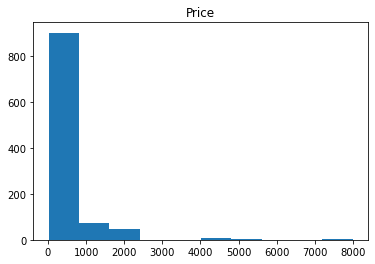

In [10]:
import matplotlib.pyplot as plt

plt.title('Price')
plt.hist(df.Price)
plt.show()

### Most of the prices are between cheaper then 900 dollars approximately.

### Check the distributions of the features:

In [11]:
import numpy as np
floats = df.select_dtypes(include=np.float64).columns.tolist()
ints = 'Release date'
floats = set(floats) - set('Price')

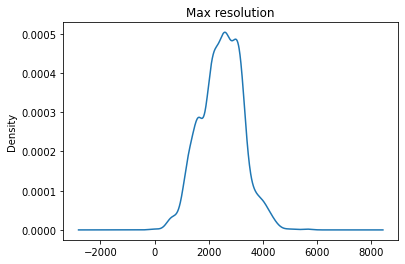

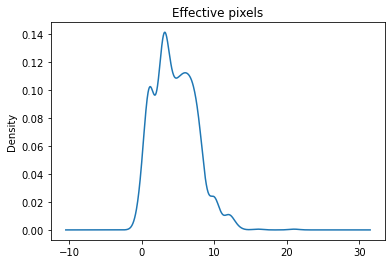

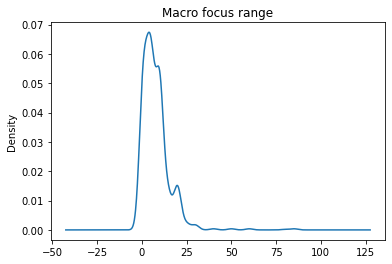

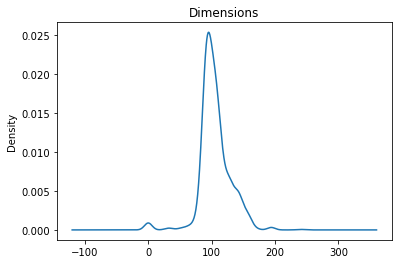

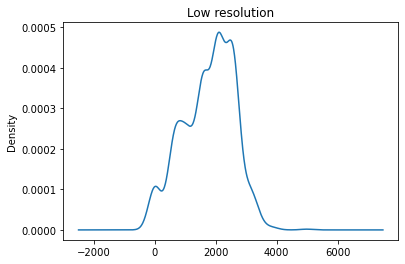

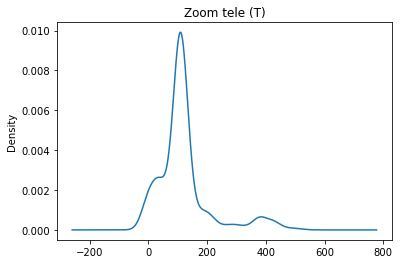

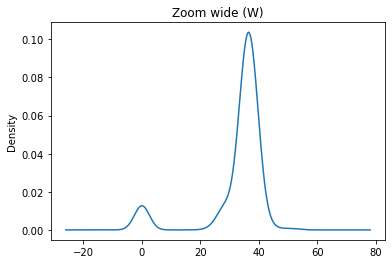

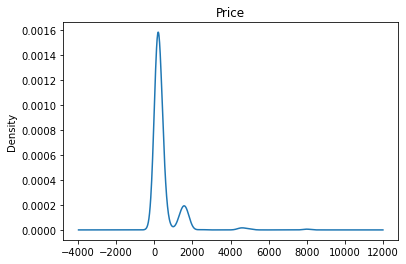

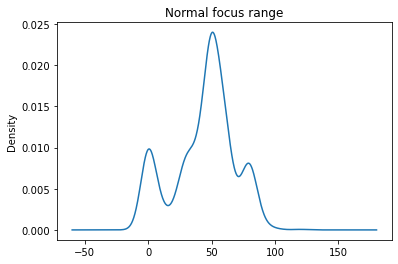

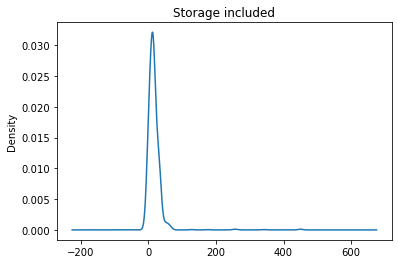

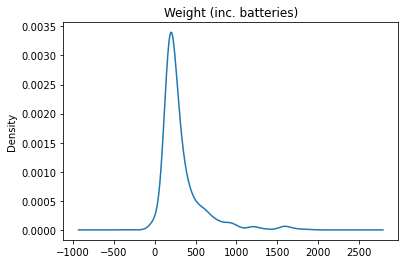

In [12]:
for feat in floats:
    plt.title(feat)
    df[feat].plot(kind='kde')
    plt.show()

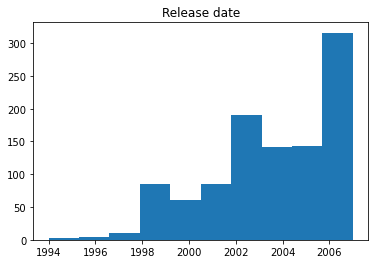

In [13]:
plt.title(ints)
plt.hist(df[ints])
plt.show()

### Check correlations within our dataset:

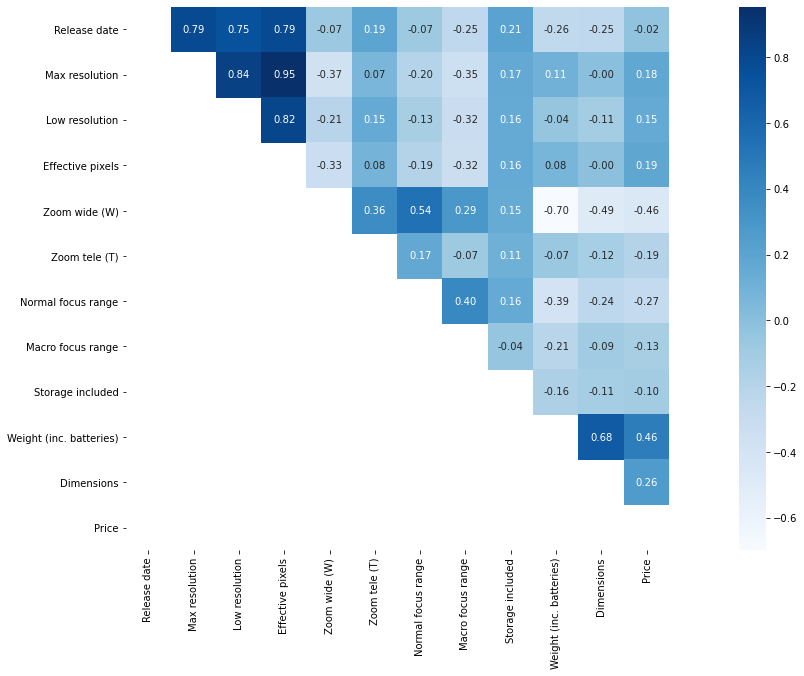

In [14]:
import seaborn as sns

corr = df.corr()
mask = np.tril(np.ones_like(corr, dtype=np.bool))
ax = plt.figure(figsize=(25,10))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f", mask = mask, square = True, cmap="Blues")

### We can notice significant correlations between the target and 'Weight' and 'Dimensions' and 'Zoom wide'.

### We'll take care of our null values by filling the relevant medians:

In [15]:
df.isnull().sum()

Release date               0
Max resolution             0
Low resolution             0
Effective pixels           0
Zoom wide (W)              0
Zoom tele (T)              0
Normal focus range         0
Macro focus range          1
Storage included           2
Weight (inc. batteries)    2
Dimensions                 2
Price                      0
dtype: int64

In [16]:
for feat in ['Macro focus range','Storage included','Weight (inc. batteries)','Dimensions']:
    median = df.loc[df[feat].notnull(), feat].median()
    df[feat].fillna(median,inplace=True)

In [17]:
df.isnull().sum()

Release date               0
Max resolution             0
Low resolution             0
Effective pixels           0
Zoom wide (W)              0
Zoom tele (T)              0
Normal focus range         0
Macro focus range          0
Storage included           0
Weight (inc. batteries)    0
Dimensions                 0
Price                      0
dtype: int64

### Feature selection:

In [18]:
import statsmodels.api as sm


def forward_selection(data, target, significance_level=0.05):
    
    initial_features = data.columns.tolist()
    best_features = []
    
    while (len(initial_features) > 0):
        
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index = remaining_features)
        
        for new_column in remaining_features:
            model = sm.OLS(target, sm.add_constant(data[best_features+
                                                        [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        
        min_p_value = new_pval.min()
        
        if(min_p_value < significance_level):
            best_features.append(new_pval.idxmin())
        else:
            break
            
    return best_features

In [19]:
features = df.drop('Price', axis=1).copy()

In [20]:
df_best = forward_selection(features, df['Price'])

<ipython-input-18-fb3f83d005e1>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index = remaining_features)


### Splitting:

In [22]:
X = df[df_best].copy()
y = df['Price'].copy()

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [24]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((830, 7), (208, 7), (830,), (208,))

### We'll train and predict using LogisticRegression:

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

reg = LinearRegression()
reg.fit(X_train, y_train)
r2 = reg.score(X_test, y_test) 
y_pred = reg.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R2 score- {r2}')
print(f'RMSE score- {RMSE}')

R2 score- 0.3686103310604566
RMSE score- 640.7457489679784


## 2. Save you model, predict with saved model

Simulate in this notebook code that will happen during training on the **training server**:
- Using `pickle`, save your model to disk. Reference: https://scikit-learn.org/stable/modules/model_persistence.html
- Save the test dataset to file.  What's a good format(s) for saving datasets?

In [26]:
import pickle

with open('d://downloads//reg.pickle', 'wb') as f:
    pickle.dump(reg, f)

### We'll save the test data to a csv file (located in my downloads file, like the pickle file)

In [27]:
X_test.to_csv('d://downloads//X_test.csv', index=False)
y_test.to_csv('d://downloads//y_test.csv', index=False)

Simulate in this notebook code that will happen during inference on the **inference server**:
- Load the model again with `pickle`.
- Read the test dataset file, and perform some predictions
- Compare the predictions received before saving the model, and after reading a saved model.  Show that you get the same results. 

In [28]:
# your code here
X_test2 = pd.read_csv('d://downloads//X_test.csv')
y_test2 = pd.read_csv('d://downloads//y_test.csv')



In [29]:
with open('d://downloads//reg.pickle','rb') as f:
    reg2 = pickle.load(f)

### We'll check that the R2 score and the predictions are identical:

In [30]:
reg2.score(X_test2, y_test2)

0.3686103310604566

In [31]:
y_pred2 = reg2.predict(X_test2)

In [32]:
(y_pred2 == y_pred).all()

True

## 3. Serve your model - using URL parameters

Now we are done with **training server**, since we have the saved model.  From now all that's relevant is **inference server** and **client** code.

Let's create the **inference server** that answers to REST APIs with predictions:

- Using `flask`, create a Pycharm project and implement the following prediction API:
- **Single prediction API** that receives inputs as parameters (no body), and returns a single prediction as a string / text.  
- Example: http://localhost:5000/predict_single?key1=value1&key2=value2 (replace `key1`, `value1` etc. names with your relevant feature names and values) that would return the class label (example: `0` / `1`)
- **Important:** For efficiency purposes, consider what's the best place in your code to put the code that reads the model.  Why?
- **Important:** In general, take runtime efficiency into account.  Your API might be called large number of times per second, and you will be paying for more inference servers if your code is not efficient.
- Copy your **inference server** code also here for reference

In [ ]:
# your code here
from flask import Flask, request
import pickle
import pandas as pd
import json

app = Flask(__name__)
app.secret_key = 'secret'

INDEX = ['Weight', 'Zoom_wide', 'Low_resolution', 'Zoom_tele',
     'Dimensions', 'Max_resolution', 'Effective_pixels']

with open('d://downloads//reg.pickle', 'rb') as f:
    MODEL = pickle.load(f)


def make_pred(params):
    df = pd.DataFrame(params, index=INDEX).T
    prediction = MODEL.predict(df)
    return prediction


@app.route('/predict_single', methods=['GET'])
def predict_single():
    Effective_pixels = request.args.get('Effective pixels', default=0)
    Max_resolution = request.args.get('Max resolution', default=0)
    Dimensions = request.args.get('Dimensions', default=0)
    Zoom_tele = request.args.get('Zoom tele (T)', default=0)
    Low_resolution = request.args.get('Low resolution', default=0)
    Zoom_wide = request.args.get('Zoom wide (W)', default=0)
    Weight = request.args.get('Weight (inc. batteries)', default=0)

    params_list = list([Weight, Zoom_wide, Low_resolution, Zoom_tele,
                        Dimensions, Max_resolution, Effective_pixels])

    prediction = make_pred(params_list)

    return 'Prediction- ' + str(prediction[0])

if __name__ == '__main__':
    app.run(debug=True)

## 4. Consume your model with python

#### Simulate client requests for inference / prediction:
Assume your client runs Python code also, and not only your training and inference servers (in real case scenario, often times your client code will actually not be in Python).
Use Python `requests` module from here to request a prediction by the client from to the inference .  To pass parameters with Python `requests` module, use the `params` parameter of `requests.get` API.

**Print input and output of the prediction.**

**Warning**: don't get used to seeing it in a Jupyter notebook.  This code will usually run inside a **client application**

In [ ]:
# your code here
import requests
import pandas as pd
import random
import json

INFERENCE_URL = 'http://127.0.0.1:5000/'
X_TEST = pd.read_csv("d://downloads//X_test.csv")


def predict_single():
    print('Predicting a single value using GET:')
    url = INFERENCE_URL + 'predict_single'
    for i in range(5):
        params = dict(X_TEST.iloc[random.randint(0, len(X_TEST)), :])
        pred = requests.get(url, params=params)
        print(f'The prediction for these parameters- {params}'
              f' is- {pred.text}')

if __name__ == '__main__':
    predict_single()    

### Output:

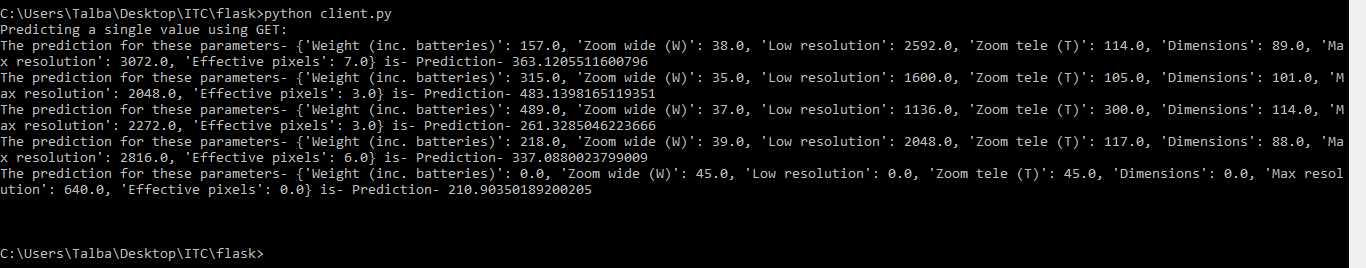


## 5. Serve your model - using JSON files

- Using `flask`, add code to your previous file in Pycharm **with inference code** to create the following prediction API (in addition to **Single prediction API** done above):
- **Multiple prediction API** that receives input many observations to predict on as a json file in the body, and returns a json file with predictions.
- Your **JSON** file format has to be efficient, clear and following JSON file syntax: 
  - JSON file is a nested structure of potentially multiple dictionaries and lists 
  - JSON file tip: Use lists, every member in the list can be a dictionary of all the features.  
  - JSON file tip: Do not put indexes of predictions into the JSON files, indexes of predictions can be easily computed with Python code later 
  - JSON files are sometimes slightly verbose, but are extremely human readable.  Just looking at your JSON files of input and output, is it possible to understand what were the observations in input and what were the predictions in output?
  - See https://www.json.org/json-en.html for JSON format
- Think about efficiency of your code - your REST API might be called a huge number of times, with a huge number of observations every time.  Can part of the code be done only once?  Can you predict on everything together? Can you do less or cheaper data conversions?
- Example of URL that will be used to predict: http://localhost:5000/car-price
- Reference for working with JSONs in Flask: https://pythonise.com/series/learning-flask/working-with-json-in-flask
- Do you need a GET or a POST type of REST API call? Does it change what you did in step 3?  Conceptually, would you say it makes sense to use GET or POST types for predictions?
- Copy your **inference server** code also here for reference 

In [2]:
# your code here
@app.route('/predict_multiple', methods=['POST'])
def predict_multiple():
    my_json = request.get_json()
    my_json = json.loads(my_json)
    for i in my_json:
        Weight = i[0]['Weight (inc. batteries)']
        Zoom_wide = i[0]['Zoom wide (W)']
        Low_resolution = i[0]['Low resolution']
        Zoom_tele = i[0]['Zoom tele (T)']
        Dimensions = i[0]['Dimensions']
        Max_resolution = i[0]['Max resolution']
        Effective_pixels = i[0]['Effective pixels']

        params_list = list([Weight, Zoom_wide, Low_resolution, Zoom_tele,
                        Dimensions, Max_resolution, Effective_pixels])

        prediction = make_pred(params_list)
        i[0]['prediction'] = prediction[0]

    return json.dumps(my_json)

Use Python `requests` module from here to make a prediction, and **print the input, and the output** of the prediction (or part of it if it's too large).  

**Hint:** to pass a JSON file to the `requests` module, use `json` parameter of the `requests.post` API.

**Warning**: don't get used to seeing it in a Jupyter notebook.  This code will usually run inside a **client application**

In [2]:
# your code here
def predict_multiple():
    print('Predicting multiple values using POST:')
    url = INFERENCE_URL + 'predict_multiple'

    rand = random.randint(0, len(X_TEST))
    len_preds = 5
    preds = X_TEST.iloc[rand:(rand+len_preds), :]

    my_json = [[] for _ in range(len(preds))]
    for i in range(len(preds)):
        my_json[i].append(dict(preds.iloc[i, :]))

    print('Predicting these values:')
    print(my_json)
    print()
    pred = requests.post(url, json=json.dumps(my_json))
    print("Predictions for these values (added a 'prediction' value for the JSON")
    print(pred.json())


### Final output:

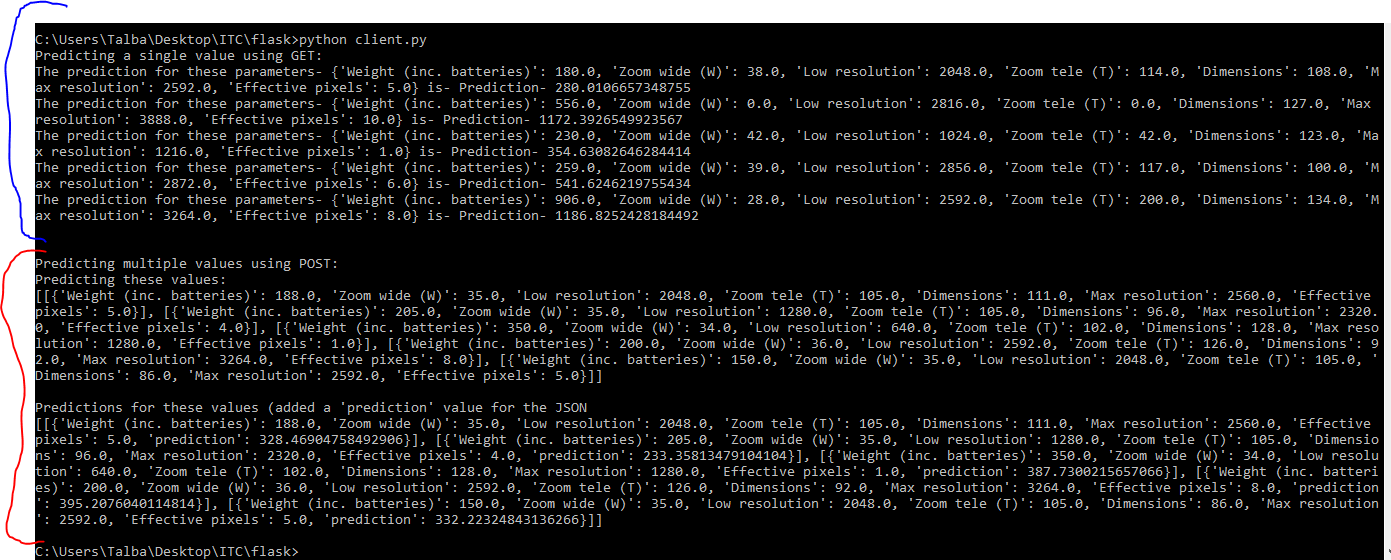

## 6. Submit a zip file with:
1. This notebook
2. Your Python inference server file